# Compare sources of plastics and ammonia production in European countries

In [88]:
import pandas as pd

import sys
import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append('../../src/construct/')
import util

In [35]:
contributions = {  # Main contributing countries to demand for "converters" (feedstock for plastic production) according to plastics Europe 2019
    'DE': 0.246,
    'IT': 0.139,
    'FR': 0.094,
    'ES': 0.076,
    'UK': 0.073,
    'PL': 0.068,
    'NL': 0.043,
    'BE': 0.046,
    'CZ': 0.026,
    'AT': 0.022,
    'SE': 0.018,
    'PT': 0.018,
    'HU': 0.016,
    'RO': 0.015,
    'CH': 0.014,
    'GR': 0.013,
    'FI': 0.011,
    'DK': 0.010,
    'SK': 0.010,
    'BG': 0.008,
    'IE': 0.006,
    'NO': 0.006,
    'SL': 0.005,
    'HR': 0.005,
    'LI': 0.005,
    'LV': 0.003,
    'EE': 0.003,
    'CY': 0.002,
}

In [63]:
prodcom = pd.read_excel('/Users/brynmorp/Data/Europe/PRODCOM/Website_snapshot_2018_N2.xlsx', sheet_name='Total Volume', skiprows=[0, 1, 3, 4, 5], index_col=0)
prodcom = prodcom.astype(str).apply(util.to_numeric)
prodcom.index = prodcom.index.astype(str)#.str[:4].astype(int)
prodcom_hvc = prodcom.loc[['20141130', '20141140']].dropna(axis=1).sum()
prodcom_hvc_contribution = prodcom_hvc.div(prodcom_hvc.loc['Volume EU28']).drop(['Volume EU27_2020', 'Volume EU28'])
prodcom_hvc_contribution = prodcom_hvc_contribution.rename({'The Netherlands': 'netherlands'}).groupby(util.get_alpha2).sum()

In [3]:
energy_balances = pd.read_csv('../../build/annual_energy_balances.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [116]:
energy_consumption = energy_balances.xs(['FC_IND_CPC_E', 'TOTAL', 2018], level=['cat_code', 'carrier_code', 'year']).droplevel(0)
non_energy_consumption_naphtha = energy_balances.xs(['FC_IND_NE', 'O4640', 2018], level=['cat_code', 'carrier_code', 'year']).droplevel(0)

In [117]:
non_energy_contribution_naphtha = non_energy_consumption_naphtha.div(non_energy_consumption_naphtha.sum())
energy_contribution = energy_consumption.div(energy_consumption.sum())

In [118]:
compare_contributions = pd.concat([
    pd.Series(contributions),
    non_energy_contribution_naphtha.reindex(contributions.keys()),
    #energy_contribution.reindex(contributions.keys()),
    prodcom_hvc_contribution.reindex(contributions.keys())
], keys=['production', 'naphtha_consumption', 'prodcom_data'], axis=1)

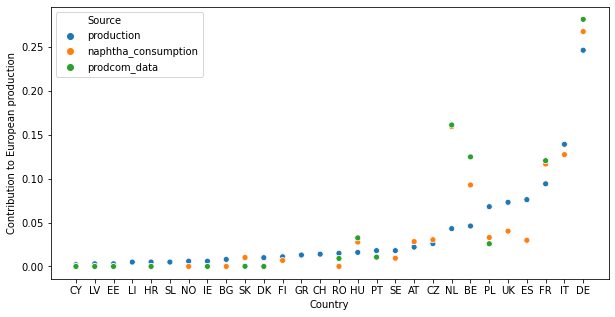

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.scatterplot(
    data=compare_contributions
    .sort_values('production')
    .stack()
    .reset_index()
    .set_axis(['Country', 'Source', 'Contribution to European production'], axis=1, inplace=False),
    x='Country', 
    y='Contribution to European production', 
    hue='Source',
    ax=ax
)

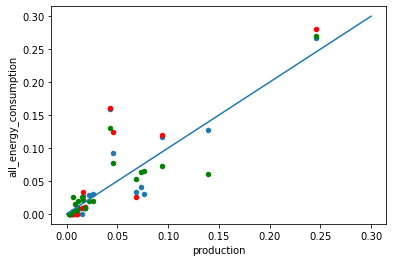

In [67]:
ax = compare_contributions.plot.scatter(x='production', y='naphtha_consumption')
compare_contributions.plot.scatter(x='production', y='prodcom_data', ax=ax, c='red')
compare_contributions.plot.scatter(x='production', y='all_energy_consumption', ax=ax, c='green')
ax.plot([0, 0.3], [0, 0.3])

In [68]:
compare_contributions.corr()

,production,naphtha_consumption,all_energy_consumption,prodcom_data
production,1.000000,0.884827,0.888045,0.888383
naphtha_consumption,0.884827,1.000000,0.941232,0.994609
all_energy_consumption,0.888045,0.941232,1.000000,0.971140
prodcom_data,0.888383,0.994609,0.971140,1.000000


# Ammonia

In [155]:
nitrates_prod = pd.read_csv('/Users/brynmorp/Data/Europe/nitrates_prod.csv', index_col=0)
nitrates_prod.index = nitrates_prod.index.map(util.get_alpha2)
nitrates_prod.columns = nitrates_prod.columns.astype(int)

non_energy_consumption_gas = (
    energy_balances
    .xs(['FC_IND_NE', 'G3000'], level=['cat_code', 'carrier_code'])
    .droplevel(0)
    .unstack()
    [[2015, 2016, 2017, 2018]]
)

ammonia_prod = prodcom.loc['20151075'].dropna(how='all').to_frame(2018)

In [156]:
ammonia_contributions = pd.concat(
    [ammonia_prod.div(ammonia_prod.loc['Volume EU28'])
     .drop(['Volume EU27_2020', 'Volume EU28', 'Base EU27_2020'])
     .rename({'The Netherlands': 'netherlands'})
     .groupby(util.get_alpha2).sum(),
     nitrates_prod.div(nitrates_prod.sum()),
     non_energy_consumption_gas.div(non_energy_consumption_gas.sum())],
    keys=['prodcom', 'fertilizers_europe', 'natural gas consumption']
)

In [161]:
ammonia_contributions = (
    ammonia_contributions
    .stack()
    .reset_index()
    .set_axis(['Source', 'Country', 'Year', 'Contribution to European production'], axis=1, inplace=False)
)

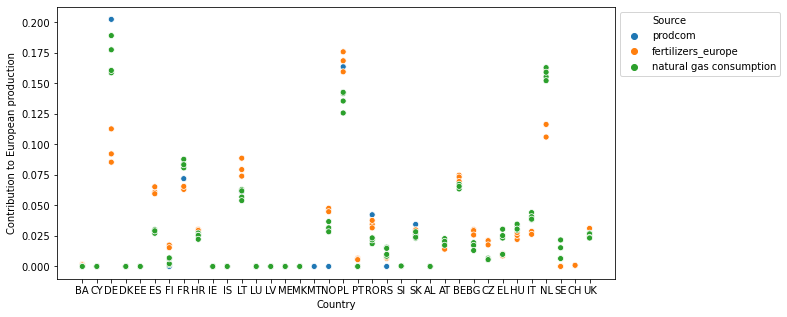

In [165]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.scatterplot(
    data=ammonia_contributions,
    x='Country',
    y='Contribution to European production',
    hue='Source',
    ax=ax
)
ax.legend(bbox_to_anchor=(1, 1))